# 05 — Modeling

Binary classification: predict whether TSLA closes **higher** the next trading day.

| Model | Type | Data |
|-------|------|------|
| Logistic Regression | Linear baseline | Scaled |
| Random Forest | Ensemble (bagging) | Unscaled |
| XGBoost | Ensemble (boosting) | Unscaled |
| Neural Net (MLP) | Deep learning | Scaled |

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay)
from src.helpers import DATA_PROCESSED

sns.set_theme(style='whitegrid')
SEED = 42

## 1. Data & Train/Test Split

Temporal split at **2024-01-01** — no random shuffle, no future data in training.

In [2]:
df = pd.read_csv(DATA_PROCESSED / 'features_ready.csv', index_col='Date', parse_dates=True).sort_index()

drop_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'target']
feature_cols = [c for c in df.columns if c not in drop_cols]
X, y = df[feature_cols], df['target'].astype(int)

SPLIT = '2024-01-01'
X_train, X_test = X[df.index < SPLIT], X[df.index >= SPLIT]
y_train, y_test = y[df.index < SPLIT], y[df.index >= SPLIT]

scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=feature_cols)
X_test_s = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=feature_cols)

print(f'Features: {len(feature_cols)}  |  Train: {len(X_train)} rows  |  Test: {len(X_test)} rows')
print(f'Train: {X_train.index.min().date()} to {X_train.index.max().date()}  |  target balance: {y_train.mean():.1%}')
print(f'Test:  {X_test.index.min().date()} to {X_test.index.max().date()}  |  target balance: {y_test.mean():.1%}')

Features: 25  |  Train: 2011 rows  |  Test: 535 rows
Train: 2016-01-05 to 2023-12-29  |  target balance: 52.2%
Test:  2024-01-02 to 2026-02-19  |  target balance: 50.1%


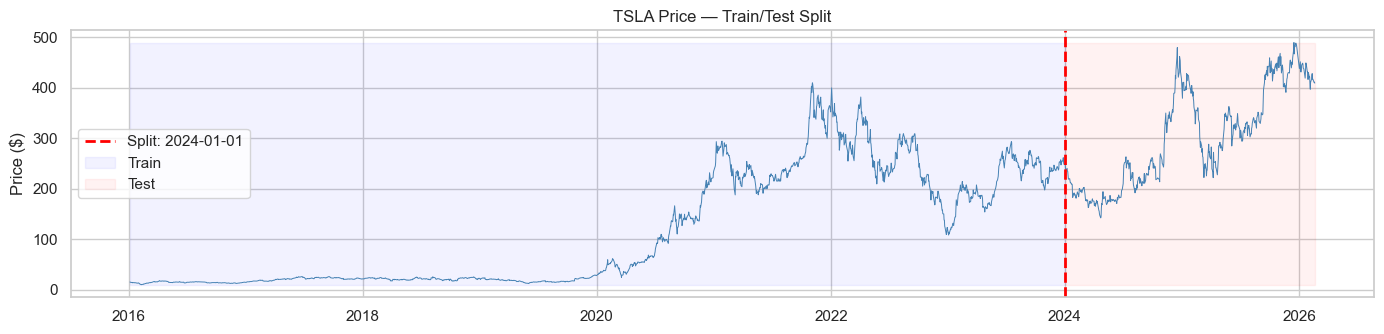

In [3]:
fig, ax = plt.subplots(figsize=(14, 3.5))
ax.plot(df.index, df['Close'], lw=0.7, color='steelblue')
ax.axvline(pd.Timestamp(SPLIT), color='red', ls='--', lw=2, label=f'Split: {SPLIT}')
ax.fill_betweenx([df['Close'].min(), df['Close'].max()], df.index.min(), pd.Timestamp(SPLIT), alpha=0.05, color='blue', label='Train')
ax.fill_betweenx([df['Close'].min(), df['Close'].max()], pd.Timestamp(SPLIT), df.index.max(), alpha=0.05, color='red', label='Test')
ax.set_title('TSLA Price — Train/Test Split')
ax.set_ylabel('Price ($)')
ax.legend()
plt.tight_layout()
plt.show()

## 2. Model Training

All models use **TimeSeriesSplit (5 folds)** for cross-validation on the training set, then are evaluated on the held-out test set.

In [4]:
tscv = TimeSeriesSplit(n_splits=5)
SCORING = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=SEED, C=1.0), True),
    'Random Forest': (RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=20, random_state=SEED, n_jobs=-1), False),
    'XGBoost': (XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=SEED, eval_metric='logloss'), False),
    'Neural Net (MLP)': (MLPClassifier(hidden_layer_sizes=(64, 32), alpha=1e-4, batch_size=64, learning_rate_init=1e-3, max_iter=200, early_stopping=True, random_state=SEED, verbose=False), True),
}

cv_rows, test_rows = [], []
fitted, preds, probs = {}, {}, {}

for name, (model, scaled) in models.items():
    Xtr = X_train_s if scaled else X_train
    Xte = X_test_s if scaled else X_test

    # Cross-validation
    cv = cross_validate(model, Xtr, y_train, cv=tscv, scoring=SCORING, n_jobs=-1)
    cv_row = {'Model': name}
    for s in SCORING:
        cv_row[s] = f"{cv[f'test_{s}'].mean():.3f} +/- {cv[f'test_{s}'].std():.3f}"
    cv_rows.append(cv_row)

    # Fit on full train, evaluate on test
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    y_prob = model.predict_proba(Xte)[:, 1]

    fitted[name] = model
    preds[name] = y_pred
    probs[name] = y_prob

    test_rows.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_prob),
    })
    print(f'{name:25s}  acc={test_rows[-1]["Accuracy"]:.3f}  f1={test_rows[-1]["F1"]:.3f}  auc={test_rows[-1]["AUC"]:.3f}')

print(f'\nBaseline (always predict majority): {max(y_test.mean(), 1-y_test.mean()):.3f}')

test_df = pd.DataFrame(test_rows).set_index('Model')

Logistic Regression        acc=0.555  f1=0.417  auc=0.622
Random Forest              acc=0.579  f1=0.505  auc=0.635
XGBoost                    acc=0.564  f1=0.410  auc=0.626
Neural Net (MLP)           acc=0.570  f1=0.368  auc=0.637

Baseline (always predict majority): 0.501


## 3. Hyperparameter Tuning

Use **RandomizedSearchCV** with TimeSeriesSplit to find better hyperparameters for each model.

In [5]:
print('Default parameters used in Section 2:\n')
defaults = {
    'Logistic Regression': {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'},
    'Random Forest': {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 20},
    'XGBoost': {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8},
    'Neural Net (MLP)': {'hidden_layer_sizes': (64, 32), 'alpha': 1e-4, 'learning_rate_init': 1e-3, 'batch_size': 64},
}
for name, params in defaults.items():
    print(f'{name:25s}  {params}')

Default parameters used in Section 2:

Logistic Regression        {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Random Forest              {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 20}
XGBoost                    {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8}
Neural Net (MLP)           {'hidden_layer_sizes': (64, 32), 'alpha': 0.0001, 'learning_rate_init': 0.001, 'batch_size': 64}


In [6]:
from sklearn.model_selection import RandomizedSearchCV

param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0], 'penalty': ['l1', 'l2'], 'solver': ['saga']},
    'Random Forest': {'n_estimators': [100, 200, 300, 500], 'max_depth': [5, 7, 10, 15, None], 'min_samples_leaf': [10, 20, 30, 50], 'max_features': ['sqrt', 'log2', 0.3, 0.5]},
    'XGBoost': {'n_estimators': [100, 200, 300, 500], 'max_depth': [3, 4, 5, 7], 'learning_rate': [0.01, 0.03, 0.05, 0.1], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9], 'reg_alpha': [0, 0.1, 0.5, 1.0], 'reg_lambda': [0.5, 1.0, 2.0]},
    'Neural Net (MLP)': {'hidden_layer_sizes': [(32,), (64, 32), (128, 64), (64, 32, 16)], 'alpha': [1e-5, 1e-4, 1e-3, 1e-2], 'learning_rate_init': [5e-4, 1e-3, 3e-3], 'batch_size': [32, 64, 128]},
}

base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=SEED),
    'Random Forest': RandomForestClassifier(random_state=SEED, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=SEED, eval_metric='logloss'),
    'Neural Net (MLP)': MLPClassifier(early_stopping=True, max_iter=200, random_state=SEED, verbose=False),
}

needs_scaling = {'Logistic Regression', 'Neural Net (MLP)'}
tuned_models = {}

for name in base_models:
    Xtr = X_train_s if name in needs_scaling else X_train
    search = RandomizedSearchCV(
        base_models[name], param_grids[name],
        n_iter=30, cv=tscv, scoring='roc_auc',
        random_state=SEED, n_jobs=-1, refit=True
    )
    search.fit(Xtr, y_train)
    tuned_models[name] = search.best_estimator_
    print(f'{name:25s}  best CV AUC={search.best_score_:.4f}')
    print(f'  params: {search.best_params_}')

Logistic Regression        best CV AUC=0.5714
  params: {'solver': 'saga', 'penalty': 'l1', 'C': 0.1}
Random Forest              best CV AUC=0.5552
  params: {'n_estimators': 500, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 15}
XGBoost                    best CV AUC=0.5639
  params: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
Neural Net (MLP)           best CV AUC=0.5602
  params: {'learning_rate_init': 0.003, 'hidden_layer_sizes': (128, 64), 'batch_size': 64, 'alpha': 0.0001}


## 3b. Optuna — XGBoost Deep Tuning

RandomizedSearchCV only tested 30 random combinations. Optuna uses Bayesian optimization (TPE) to intelligently search **500 trials**.

**Why did 1,000 trials previously make things worse?** Meta-overfitting — with ~2,000 training rows and 5 CV folds, the TPE sampler found hyperparameters that exploited noise in the specific fold boundaries rather than real signal. CV AUC went up (0.5789) but test AUC went down (0.5921 vs 0.6265).

**Anti-overfitting strategy:**
- **Temporal holdout selection** — Optuna optimizes CV AUC on the first 80% of training data to explore the space, then the **top 20 trials are re-evaluated** on a held-out temporal slice (last 20% of training, ~mid-2023 to end-2023) that Optuna never optimizes against. The final model is selected by this holdout AUC, breaking the meta-overfitting loop.
- **Tighter, more discrete search space** — categorical choices for key params reduce suspiciously precise values
- **Strong regularization floor** — `min_child_weight >= 5`, `reg_alpha >= 0.1`, `gamma >= 0.1`

In [7]:
import optuna
from sklearn.model_selection import cross_val_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- Temporal holdout: split training data 80/20 ---
holdout_split = int(len(X_train) * 0.80)
X_opt_train, X_holdout = X_train.iloc[:holdout_split], X_train.iloc[holdout_split:]
y_opt_train, y_holdout = y_train.iloc[:holdout_split], y_train.iloc[holdout_split:]
tscv_opt = TimeSeriesSplit(n_splits=5)

print(f'Optuna train: {len(X_opt_train)} rows ({X_opt_train.index.min().date()} to {X_opt_train.index.max().date()})')
print(f'Holdout:      {len(X_holdout)} rows ({X_holdout.index.min().date()} to {X_holdout.index.max().date()})')
print(f'Test:         {len(X_test)} rows ({X_test.index.min().date()} to {X_test.index.max().date()})')

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 150, 200, 300, 400, 500]),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.03, 0.05, 0.08, 0.1]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0.1, 0.3, 0.5, 1.0, 2.0, 5.0]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1.0, 2.0, 3.0, 5.0]),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 30),
        'gamma': trial.suggest_categorical('gamma', [0.1, 0.3, 0.5, 1.0, 2.0]),
        'random_state': SEED,
        'eval_metric': 'logloss',
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_opt_train, y_opt_train, cv=tscv_opt, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
)
study.optimize(xgb_objective, n_trials=500, show_progress_bar=True)

print(f'\nTrials completed: {len(study.trials)}')
print(f'Best CV AUC (on 80% train): {study.best_value:.4f}')
print(f'Best CV params: {study.best_params}')

# --- Re-evaluate top 20 trials on temporal holdout ---
top_trials = sorted(study.trials, key=lambda t: t.value if t.value else 0, reverse=True)[:20]

best_holdout_auc = 0
best_holdout_params = None

print(f'\nRe-evaluating top 20 trials on temporal holdout ({len(X_holdout)} rows):')
for i, trial in enumerate(top_trials):
    params = {k: v for k, v in trial.params.items()}
    params['random_state'] = SEED
    params['eval_metric'] = 'logloss'
    model = XGBClassifier(**params)
    model.fit(X_opt_train, y_opt_train)
    holdout_prob = model.predict_proba(X_holdout)[:, 1]
    holdout_auc = roc_auc_score(y_holdout, holdout_prob)
    if holdout_auc > best_holdout_auc:
        best_holdout_auc = holdout_auc
        best_holdout_params = params
    if i < 5:
        print(f'  Trial {trial.number:>3d}: CV AUC={trial.value:.4f}  Holdout AUC={holdout_auc:.4f}')

print(f'\nSelected by holdout — AUC={best_holdout_auc:.4f}')
print(f'Params: { {k: v for k, v in best_holdout_params.items() if k not in ("random_state", "eval_metric")} }')

Optuna train: 1608 rows (2016-01-05 to 2022-05-23)
Holdout:      403 rows (2022-05-24 to 2023-12-29)
Test:         535 rows (2024-01-02 to 2026-02-19)


  0%|          | 0/500 [00:00<?, ?it/s]


Trials completed: 500
Best CV AUC (on 80% train): 0.5514
Best CV params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.08, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 0.1, 'reg_lambda': 2.0, 'min_child_weight': 11, 'gamma': 0.5}

Re-evaluating top 20 trials on temporal holdout (403 rows):
  Trial 260: CV AUC=0.5514  Holdout AUC=0.6055
  Trial 294: CV AUC=0.5514  Holdout AUC=0.6055
  Trial 297: CV AUC=0.5514  Holdout AUC=0.6055
  Trial 299: CV AUC=0.5514  Holdout AUC=0.6055
  Trial 301: CV AUC=0.5514  Holdout AUC=0.6055

Selected by holdout — AUC=0.6055
Params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.08, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 0.1, 'reg_lambda': 2.0, 'min_child_weight': 11, 'gamma': 0.5}


In [8]:
# Fit holdout-selected XGBoost on FULL training set, then evaluate on test
xgb_optuna = XGBClassifier(**best_holdout_params)
xgb_optuna.fit(X_train, y_train)

y_pred_optuna = xgb_optuna.predict(X_test)
y_prob_optuna = xgb_optuna.predict_proba(X_test)[:, 1]

# Replace in tuned_models so downstream cells use it
tuned_models['XGBoost'] = xgb_optuna

# RandomSearch best params (from Section 3 above)
rs_params = {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.6}
xgb_rs = XGBClassifier(**rs_params, random_state=SEED, eval_metric='logloss')
xgb_rs.fit(X_train, y_train)
y_pred_rs = xgb_rs.predict(X_test)
y_prob_rs = xgb_rs.predict_proba(X_test)[:, 1]

print('XGBoost — Test Set Comparison:')
print(f'  {"":25s} {"Accuracy":>10s} {"F1":>10s} {"AUC":>10s}')
print(f'  {"Default":25s} {accuracy_score(y_test, preds["XGBoost"]):10.4f} {f1_score(y_test, preds["XGBoost"]):10.4f} {roc_auc_score(y_test, probs["XGBoost"]):10.4f}')
print(f'  {"RandomSearch (30)":25s} {accuracy_score(y_test, y_pred_rs):10.4f} {f1_score(y_test, y_pred_rs):10.4f} {roc_auc_score(y_test, y_prob_rs):10.4f}')
print(f'  {"Optuna (holdout-sel.)":25s} {accuracy_score(y_test, y_pred_optuna):10.4f} {f1_score(y_test, y_pred_optuna):10.4f} {roc_auc_score(y_test, y_prob_optuna):10.4f}')

XGBoost — Test Set Comparison:
                              Accuracy         F1        AUC
  Default                       0.5645     0.4101     0.6257
  RandomSearch (30)             0.5888     0.4737     0.6444
  Optuna (holdout-sel.)         0.5533     0.4010     0.5888


## 3c. Optuna — Neural Net (MLP) Tuning

sklearn's MLPClassifier has few tunable knobs (no dropout, no learning-rate scheduler), so **200 trials** is sufficient — more would risk overfitting the CV folds on ~2,000 training rows.

Search space:
- **Architecture**: 1–3 layers, 16–256 neurons per layer
- **Regularization (alpha)**: L2 penalty — the MLP's main overfitting control
- **Learning rate & batch size**: affect convergence and generalization
- **Activation function**: relu vs tanh
- **max_iter**: up to 500 epochs with early stopping

In [9]:
def mlp_objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i}', 16, 256, log=True))
    
    params = {
        'hidden_layer_sizes': tuple(layers),
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'early_stopping': True,
        'max_iter': 500,
        'random_state': SEED,
        'verbose': False,
        'validation_fraction': 0.15,
        'n_iter_no_change': 15,
    }
    model = MLPClassifier(**params)
    scores = cross_val_score(model, X_train_s, y_train, cv=tscv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study_mlp = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_mlp.optimize(mlp_objective, n_trials=200, show_progress_bar=True)

print(f'Best CV AUC: {study_mlp.best_value:.4f}')
print(f'Best params: {study_mlp.best_params}')

  0%|          | 0/200 [00:00<?, ?it/s]

Best CV AUC: 0.5819
Best params: {'n_layers': 2, 'n_units_l0': 170, 'n_units_l1': 29, 'alpha': 0.0005174503473175281, 'learning_rate_init': 0.000859519898265336, 'batch_size': 16, 'activation': 'relu'}


In [10]:
# Reconstruct best MLP architecture from Optuna params
best_mlp_params = study_mlp.best_params
n_layers = best_mlp_params['n_layers']
best_layers = tuple(best_mlp_params[f'n_units_l{i}'] for i in range(n_layers))

mlp_optuna = MLPClassifier(
    hidden_layer_sizes=best_layers,
    alpha=best_mlp_params['alpha'],
    learning_rate_init=best_mlp_params['learning_rate_init'],
    batch_size=best_mlp_params['batch_size'],
    activation=best_mlp_params['activation'],
    early_stopping=True, max_iter=500, random_state=SEED, verbose=False,
    validation_fraction=0.15, n_iter_no_change=15,
)
mlp_optuna.fit(X_train_s, y_train)

y_pred_mlp_optuna = mlp_optuna.predict(X_test_s)
y_prob_mlp_optuna = mlp_optuna.predict_proba(X_test_s)[:, 1]

# Replace in tuned_models
tuned_models['Neural Net (MLP)'] = mlp_optuna

# Get default MLP results for comparison
mlp_rs = fitted['Neural Net (MLP)']
y_pred_mlp_rs = preds['Neural Net (MLP)']
y_prob_mlp_rs = probs['Neural Net (MLP)']

print(f'Optuna MLP architecture: {best_layers}')
print(f'Neural Net — Test Set Comparison:')
print(f'  {"":20s} {"Accuracy":>10s} {"F1":>10s} {"AUC":>10s}')
print(f'  {"Default (64,32)":20s} {accuracy_score(y_test, y_pred_mlp_rs):10.4f} {f1_score(y_test, y_pred_mlp_rs):10.4f} {roc_auc_score(y_test, y_prob_mlp_rs):10.4f}')
print(f'  {"Optuna (200 trials)":20s} {accuracy_score(y_test, y_pred_mlp_optuna):10.4f} {f1_score(y_test, y_pred_mlp_optuna):10.4f} {roc_auc_score(y_test, y_prob_mlp_optuna):10.4f}')

Optuna MLP architecture: (170, 29)
Neural Net — Test Set Comparison:
                         Accuracy         F1        AUC
  Default (64,32)          0.5701     0.3681     0.6369
  Optuna (200 trials)      0.5589     0.5144     0.5731


## 3d. Probability Calibration

Tree-based models (RF, XGBoost) are notoriously poorly calibrated — their raw probability outputs don't reflect true event frequencies. **Platt scaling** (sigmoid calibration) fits a logistic regression on the model's scores to correct this mapping.

This matters because our trading strategy uses a 0.50 threshold: if the model systematically outputs 0.48 when the true probability is 0.52, we make the wrong trade. Calibration fixes this without changing the model itself.

We use `method='sigmoid'` (2 parameters) rather than isotonic regression to avoid overfitting the calibration curve on ~2,000 training rows.

**Exception — Logistic Regression** is already inherently well-calibrated (it *is* a logistic function). Adding Platt scaling on top overcorrects its probabilities, causing them to drift away from 0.5 over time and resulting in the model rarely triggering trades in later years. LR is therefore kept uncalibrated.

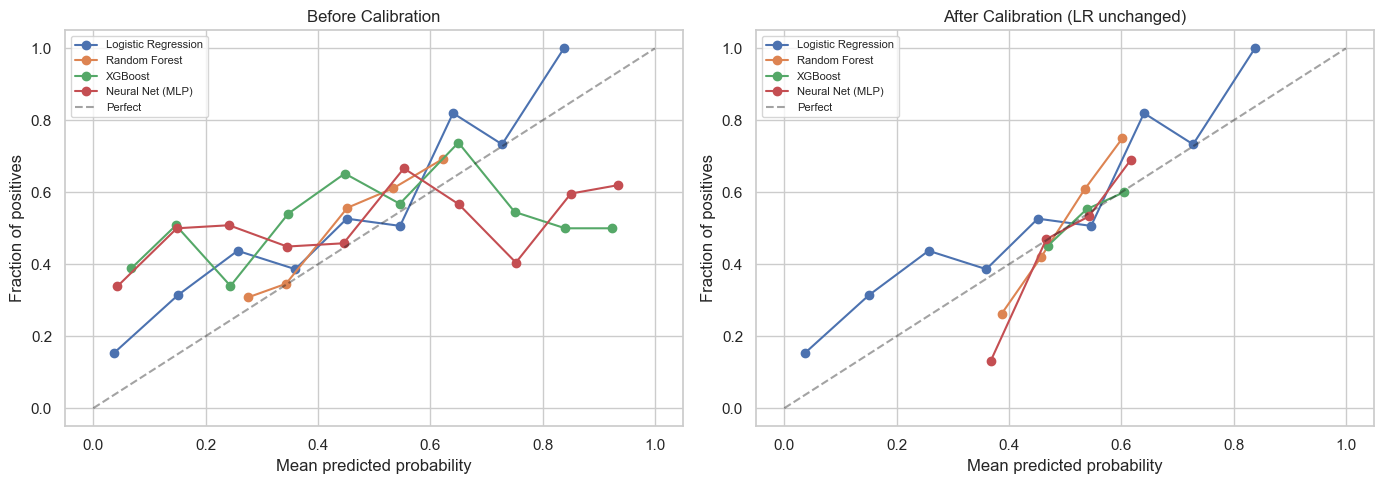

Tuned models replaced with calibrated versions (LR kept uncalibrated).


In [11]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

tscv_cal = TimeSeriesSplit(n_splits=3)

# Calibrate all tuned models EXCEPT Logistic Regression
# LR is already well-calibrated (it IS a logistic function);
# adding Platt scaling overcorrects its probabilities.
calibrated_models = {}
for name, model in tuned_models.items():
    scaled = name in {'Logistic Regression', 'Neural Net (MLP)'}
    Xtr = X_train_s if scaled else X_train

    if name == 'Logistic Regression':
        # Skip calibration — LR outputs are inherently calibrated
        calibrated_models[name] = model
    else:
        cal = CalibratedClassifierCV(model, method='sigmoid', cv=tscv_cal)
        cal.fit(Xtr, y_train)
        calibrated_models[name] = cal

# Calibration curves: before vs after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for name in tuned_models:
    scaled = name in {'Logistic Regression', 'Neural Net (MLP)'}
    Xte = X_test_s if scaled else X_test

    prob_before = tuned_models[name].predict_proba(Xte)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_before, n_bins=10)
    axes[0].plot(mean_pred, frac_pos, marker='o', label=name)

    prob_after = calibrated_models[name].predict_proba(Xte)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_after, n_bins=10)
    axes[1].plot(mean_pred, frac_pos, marker='o', label=name)

for ax, title in zip(axes, ['Before Calibration', 'After Calibration (LR unchanged)']):
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.4, label='Perfect')
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.set_title(title)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Replace tuned_models with calibrated versions for downstream evaluation
tuned_models = calibrated_models
print('Tuned models replaced with calibrated versions (LR kept uncalibrated).')

In [12]:
needs_scaling = {'Logistic Regression', 'Neural Net (MLP)'}

tuned_test_rows = []
tuned_preds, tuned_probs = {}, {}

for name, model in tuned_models.items():
    Xte = X_test_s if name in needs_scaling else X_test
    y_pred = model.predict(Xte)
    y_prob = model.predict_proba(Xte)[:, 1]
    tuned_preds[name] = y_pred
    tuned_probs[name] = y_prob
    tuned_test_rows.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_prob),
    })

tuned_df = pd.DataFrame(tuned_test_rows).set_index('Model')

print('Default vs Tuned (test set):')
comp = test_df[['Accuracy', 'AUC']].rename(columns={'Accuracy': 'Def Acc', 'AUC': 'Def AUC'})
comp['Tuned Acc'] = tuned_df['Accuracy']
comp['Tuned AUC'] = tuned_df['AUC']
comp['Acc Diff'] = comp['Tuned Acc'] - comp['Def Acc']
comp['AUC Diff'] = comp['Tuned AUC'] - comp['Def AUC']
display(comp.round(4))

Default vs Tuned (test set):


,Def Acc,Def AUC,Tuned Acc,Tuned AUC,Acc Diff,AUC Diff
Model,,,,,,
Logistic Regression,0.5551,0.6219,0.5776,0.6498,0.0224,0.0279
Random Forest,0.5794,0.6352,0.6000,0.6313,0.0206,-0.0038
XGBoost,0.5645,0.6257,0.5514,0.5607,-0.0131,-0.0651
Neural Net (MLP),0.5701,0.6369,0.5551,0.5920,-0.0150,-0.0449


## 4. Results

In [13]:
print('Cross-Validation (train set, TimeSeriesSplit k=5):')
display(pd.DataFrame(cv_rows).set_index('Model'))

print('\nTest Set — Default Parameters:')
display(test_df.round(4).style.highlight_max(axis=0, props='background-color: #d4edda'))

print('\nTest Set — Tuned Parameters:')
display(tuned_df.round(4).style.highlight_max(axis=0, props='background-color: #d4edda'))

Cross-Validation (train set, TimeSeriesSplit k=5):


,accuracy,precision,recall,f1,roc_auc
Model,,,,,
Logistic Regression,0.544 +/- 0.028,0.554 +/- 0.034,0.683 +/- 0.147,0.603 +/- 0.062,0.546 +/- 0.037
Random Forest,0.534 +/- 0.040,0.539 +/- 0.035,0.723 +/- 0.136,0.612 +/- 0.067,0.544 +/- 0.050
XGBoost,0.544 +/- 0.028,0.557 +/- 0.041,0.598 +/- 0.127,0.572 +/- 0.067,0.563 +/- 0.039
Neural Net (MLP),0.513 +/- 0.028,0.523 +/- 0.030,0.675 +/- 0.181,0.579 +/- 0.091,0.505 +/- 0.041



Test Set — Default Parameters:


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Logistic Regression,0.555100,0.607100,0.317200,0.416700,0.621900
Random Forest,0.579400,0.615000,0.429100,0.505500,0.635200
XGBoost,0.564500,0.637800,0.302200,0.410100,0.625700
Neural Net (MLP),0.570100,0.697900,0.250000,0.368100,0.636900



Test Set — Tuned Parameters:


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Logistic Regression,0.577600,0.647900,0.343300,0.448800,0.649800
Random Forest,0.600000,0.610700,0.556000,0.582000,0.631300
XGBoost,0.551400,0.553800,0.537300,0.545500,0.560700
Neural Net (MLP),0.555100,0.547800,0.641800,0.591100,0.592000


## 5. Evaluation

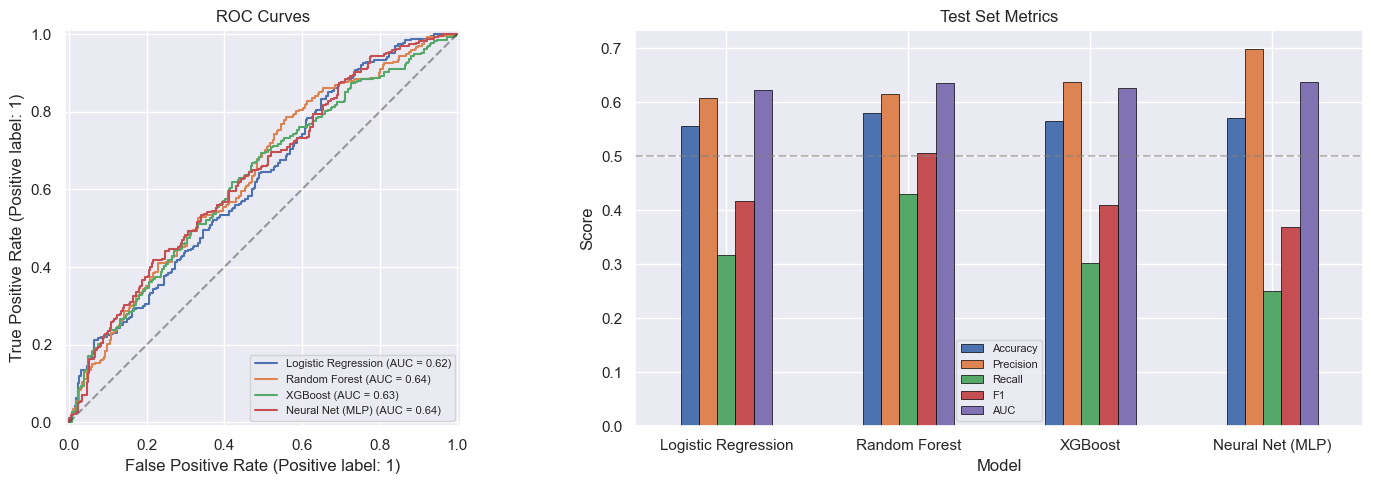

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC curves
ax = axes[0]
for name, prob in probs.items():
    RocCurveDisplay.from_predictions(y_test, prob, name=name, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.4)
ax.set_title('ROC Curves')
ax.legend(fontsize=8, loc='lower right')

# Metric comparison
ax = axes[1]
test_df[['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']].plot(kind='bar', ax=ax, rot=0, edgecolor='black', lw=0.5)
ax.axhline(0.5, color='grey', ls='--', alpha=0.5)
ax.set_title('Test Set Metrics')
ax.set_ylabel('Score')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

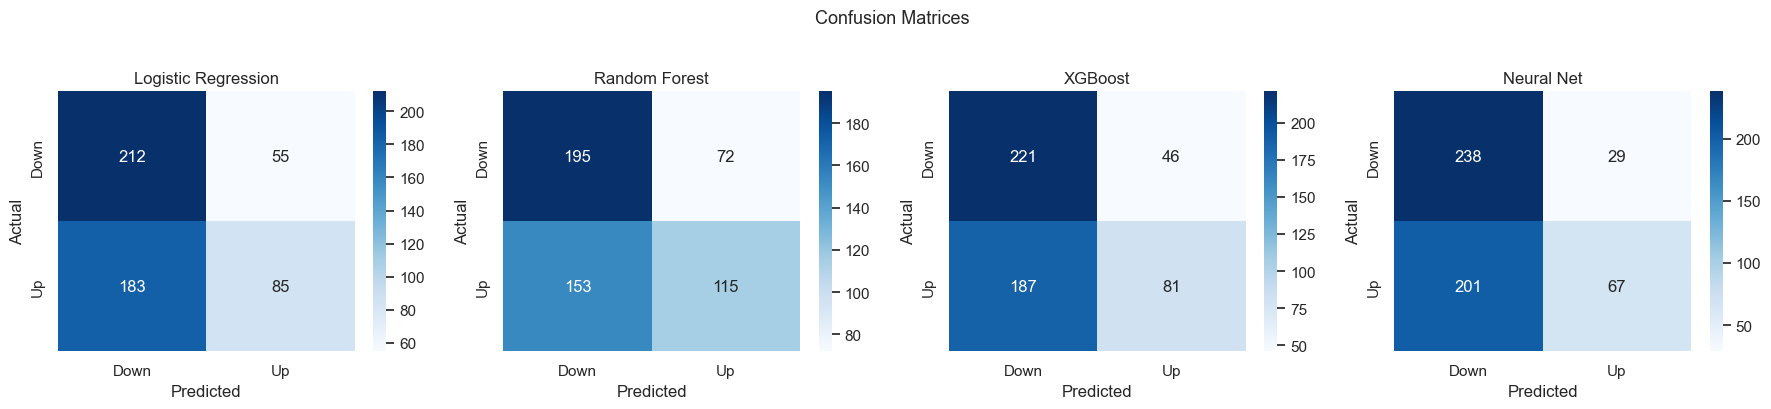

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for ax, (name, pred) in zip(axes, preds.items()):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
    ax.set_title(f'{name.split("(")[0].strip()}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.suptitle('Confusion Matrices', y=1.02, fontsize=13)
plt.tight_layout()
plt.show()

## 6. Feature Importance

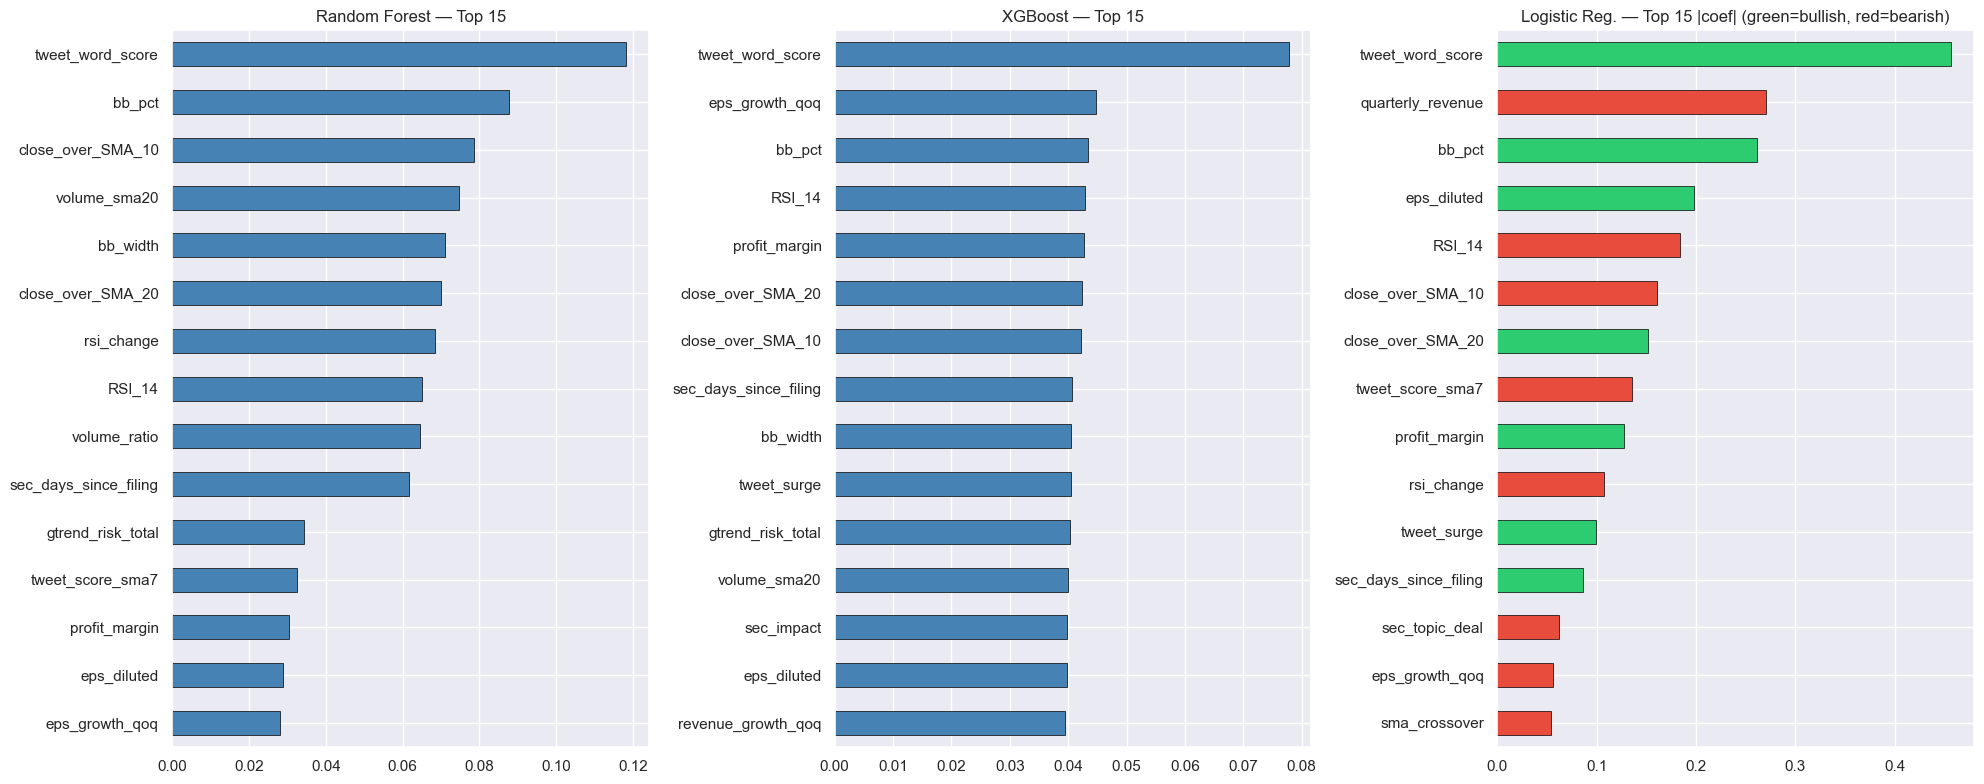

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# RF & XGBoost importances
for ax, (name, key) in zip(axes[:2], [('Random Forest', 'Random Forest'), ('XGBoost', 'XGBoost')]):
    imp = pd.Series(fitted[key].feature_importances_, index=feature_cols).sort_values()
    imp.tail(15).plot(kind='barh', ax=ax, color='steelblue', edgecolor='black', lw=0.5)
    ax.set_title(f'{name} — Top 15')

# LR coefficients
lr_coef = pd.Series(fitted['Logistic Regression'].coef_[0], index=feature_cols)
top15 = lr_coef.abs().sort_values().tail(15)
colors = ['#2ecc71' if lr_coef[c] > 0 else '#e74c3c' for c in top15.index]
top15.plot(kind='barh', ax=axes[2], color=colors, edgecolor='black', lw=0.5)
axes[2].set_title('Logistic Reg. — Top 15 |coef| (green=bullish, red=bearish)')

plt.tight_layout()
plt.show()

## 7. Rolling Accuracy

60-day rolling window to check for regime-dependent performance.

A rolling window lets us check if models perform consistently or only in certain market regimes.

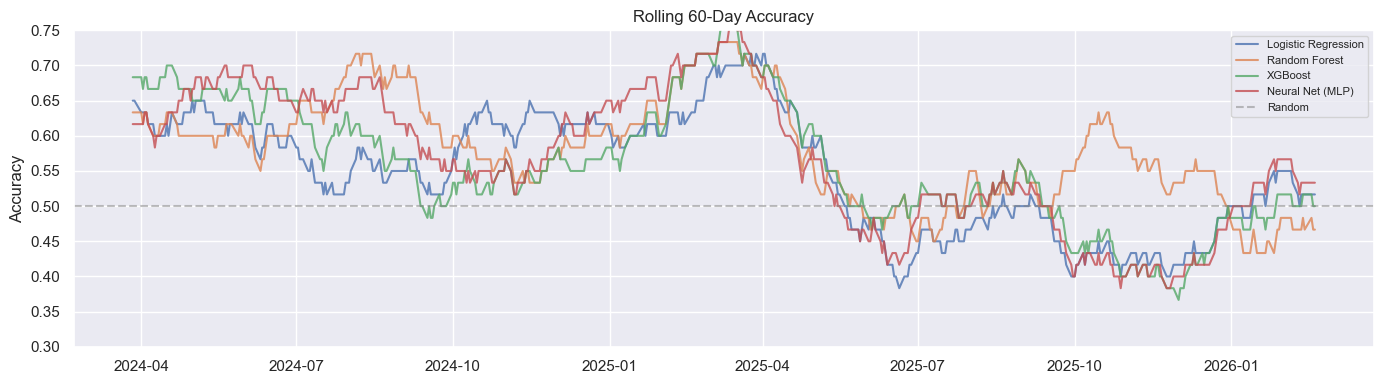

In [17]:
fig, ax = plt.subplots(figsize=(14, 4))
for name, pred in preds.items():
    correct = pd.Series((pred == y_test.values).astype(int), index=y_test.index)
    ax.plot(correct.rolling(60).mean(), label=name, alpha=0.8, lw=1.5)
ax.axhline(0.5, color='grey', ls='--', alpha=0.5, label='Random')
ax.set_title('Rolling 60-Day Accuracy')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.3, 0.75)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

## 8. Summary

In [18]:
best_f1 = tuned_df['F1'].idxmax()
best_auc = tuned_df['AUC'].idxmax()
baseline = max(y_test.mean(), 1 - y_test.mean())

print(f'Best tuned model by F1:   {best_f1} ({tuned_df.loc[best_f1, "F1"]:.3f})')
print(f'Best tuned model by AUC:  {best_auc} ({tuned_df.loc[best_auc, "AUC"]:.3f})')
print(f'Baseline accuracy:        {baseline:.3f}')
print()
print('Hyperparameter tuning results compared to default parameters above.')
print('Next step: backtesting to test if predictions translate to a trading edge.')

Best tuned model by F1:   Neural Net (MLP) (0.591)
Best tuned model by AUC:  Logistic Regression (0.650)
Baseline accuracy:        0.501

Hyperparameter tuning results compared to default parameters above.
Next step: backtesting to test if predictions translate to a trading edge.
